Given a point cloud, which includes point positions and semantic embeddings, we generate some aesthetic properties.
For example, how well does each point match the word "bed"?

In [52]:
import torch
import clip
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from typing import List

# NOTE: for now, force cpu
# select the device for computation
if False and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"using device: {device}")

OUT_DIR = "../res/out"

using device: cpu


In [53]:
# load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# load point cloud
data = json.load(open(f"{OUT_DIR}/point_cloud.json", "r"))

points = np.array([point["pos"] for point in data["cloud"]])
embeds = np.array([point["embed"] for point in data["cloud"]])

embeds.shape

(5466, 512)

In [54]:
def get_semantic_similarities(embeds: np.ndarray, phrase: str) -> np.ndarray:
    # get the similarity between a phrase and the point cloud embeddings
    text_embed = clip_model.encode_text(clip.tokenize(phrase).to(device)).cpu().detach().numpy()
    return embeds @ text_embed.T

def get_color(*sims: np.ndarray) -> List[str]:
    colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "brown"]
    assert len(sims) <= len(colors), "Too many similarity arrays!"

    sims = np.concatenate(sims, axis=1)
    maxs = np.argmax(sims, axis=1)

    # set calibration points to black (assuming only 0 embeddings result in 0 similarity)
    return [colors[i] for i in maxs]

sims = [
    get_semantic_similarities(embeds, "a photo of an object"), # red
    get_semantic_similarities(embeds, "a photo of a floor"), # green
    get_semantic_similarities(embeds, "a photo of a wall"), # blue
    get_semantic_similarities(embeds, "a photo of a ceiling"), # yellow
    get_semantic_similarities(embeds, "a photo of a window"), # purple
    get_semantic_similarities(embeds, "a photo of a chair"), # orange
    get_semantic_similarities(embeds, "a photo of a bed"), # pink
]

colors = get_color(*sims)

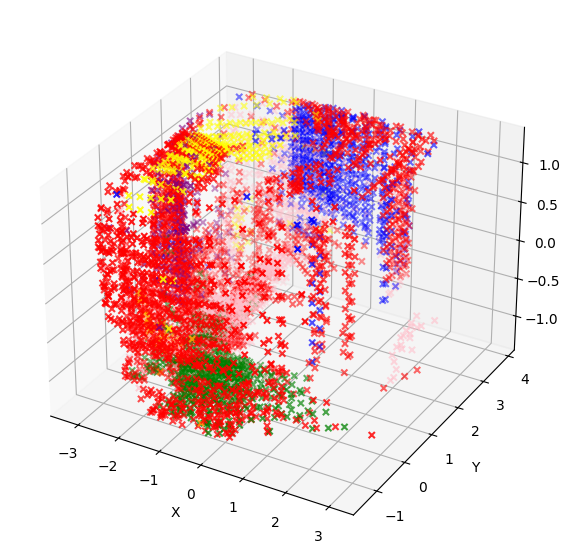

In [55]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(points[:, 2], points[:, 0], points[:, 1], c=colors, marker="x")
#fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [56]:
render_points = [
    { "pos": point.tolist(), "col": clrs.to_rgb(col), "size": 0.015 }
        for point, col in zip(points, colors) if col != "cyan"
]
render_points += [
    { "pos": point.tolist(), "col": clrs.to_rgb(col), "size": 0.07 }
        for point, col in zip(points, colors) if col == "cyan"
]

cloud = [{
        "pos": point.tolist(),
        "col": clrs.to_rgb(col),
        "size": 0.015,
    } for point, col in zip(points, colors)
]

calibration_cloud = [{
        "pos": cal["pos"],
        "col": clrs.to_rgb("cyan"),
        "size": 0.07,
    } for cal in data["calibrate"]
]

n_views = len(data["views"])
red = np.array([1, 0, 0])
view_cloud = [{
        "pos": (np.array(view["pos"]) * -np.array([1, 1, 1])).tolist(), # TODO:
        # mark a trail that transitions from white to red
        "col": (np.array(clrs.to_rgb("white")) * (1 - (n / n_views)) + red * (n / n_views)).tolist(),
        "size": 0.1,
    } for n, view in enumerate(data["views"])
]

# save point cloud for simulation re-use
json.dump(
    cloud + calibration_cloud,# + view_cloud,
    open(f"{OUT_DIR}/pretty_point_cloud.json", "w"),
)